In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
import numpy as np
import torchvision
import generators
import warnings
import utils
import torch
import os

device = 'cpu'

In [2]:
z_dim = 64 
mnist_classes, fashion_mnist_classes = 10, 10
emnist_letters_classes, celeba_classes = 27, 3
gray_shape, color_shape = (1, 28, 28), (3, 64, 64)

In [3]:
generator_input_dim1 = utils.get_input_dimensions(z_dim, mnist_classes)
sngan_wgan_gp_mnist = generators.GeneratorSNGANWGANGP_V1_0(z_dim = generator_input_dim1)
generator_input_dim2 = utils.get_input_dimensions(z_dim, fashion_mnist_classes)
sngan_wgan_gp_fashion_mnist = generators.GeneratorSNGANWGANGP_V1_0(z_dim = generator_input_dim2)
generator_input_dim3 = utils.get_input_dimensions(z_dim, emnist_letters_classes)
sngan_wgan_gp_emnist_letters = generators.GeneratorSNGANWGANGP_V1_0(z_dim = generator_input_dim3)
generator_input_dim4 = utils.get_input_dimensions(z_dim, celeba_classes)
sngan_wgan_gp_celeba = generators.GeneratorSNGANWGANGP_V2_0(input_dim = generator_input_dim4)

model_path1 = '../implemented-gans-architectures/wgan-gp-sngan/mnist/saved-models/gen_conditional_wgan_gp_sngan_mnist.pth'
model_path2 = '../implemented-gans-architectures/wgan-gp-sngan/fashion-mnist/saved-models/gen_conditional_wgan_gp_sngan_fashion_mnist.pth'
model_path3 = '../implemented-gans-architectures/wgan-gp-sngan/emnist-letters/saved-models/gen_conditional_wgan_gp_sngan_emnist_letters.pth'
model_path4 = '../implemented-gans-architectures/wgan-gp-sngan/celeba/saved-models/gen_conditional_wgan_gp_sngan_celeba.pth'

sngan_wgan_gp_mnist.load_state_dict(torch.load(model_path1, map_location = torch.device(device)))
sngan_wgan_gp_mnist.eval()
sngan_wgan_gp_fashion_mnist.load_state_dict(torch.load(model_path2, map_location = torch.device(device)))
sngan_wgan_gp_fashion_mnist.eval()
sngan_wgan_gp_emnist_letters.load_state_dict(torch.load(model_path3, map_location = torch.device(device)))
sngan_wgan_gp_emnist_letters.eval()
sngan_wgan_gp_celeba.load_state_dict(torch.load(model_path4, map_location = torch.device(device)))
sngan_wgan_gp_celeba.eval()

GeneratorSNGANWGANGP_V2_0(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(67, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): 

In [4]:
def make_fake_image(n_classes, conditional_class, model_generation, is_celeba = False):
    '''
    creates a synthetic image generated by GANs using conditioned classes.

    Input:
        n_classes (int) --> total number of classes that the model can generate.
        conditional_class (int) --> conditioned class for synthetic image generation.
        model_generation (pytorch model) --> Pytorch model of GAN to generate the synthetic image.
    Returns:
        fake_image (tensor) --> tensor of the synthetic image generated by GAN.
    '''

    noise = utils.get_noise(n_samples = 1, input_dim = z_dim, device = device)
    noise_conditional = torch.cat(tensors = (noise.float(), 
                                            F.one_hot(torch.tensor([conditional_class]), n_classes).float()), 
                                            dim = 1)
    fake = model_generation(noise_conditional)

    if is_celeba: return fake.detach().cpu().view(-1, *color_shape)[0] #.permute(1, 2, 0)
    else: return fake.detach().cpu().view(-1, *gray_shape)[0, 0]

In [5]:
def tensor_to_png(image_tensor, image_dir, is_celeba = False):
    '''
    saves an image tensor in png format.

    Input:
        image_tensor (array) --> image tensor
        image_dir (str) --> string with directory and image name.png
    Returns:
    '''
    if is_celeba:
        plt.axis('off')
        image_array = np.array(image_tensor)
        image_array = np.clip(image_array, a_min = 0, a_max = 1)
        image = Image.fromarray(image_array)
        image.save(image_dir)
            # plt.imshow(image_array, vmin = np.min(image_array), vmax = np.max(image_array))
            # plt.savefig(image_dir, bbox_inches = 'tight', pad_inches = 0)
    else:
        image = torchvision.transforms.ToPILImage()(image_tensor)
        image.save(image_dir)

In [6]:
def analyze_directory(directory, extract):
    '''
    analyzes the amount of images present in subdirectories.

    Input:
        directory (string) --> main directory to be parsed.
        extract (string) --> data extract type.
    '''

    count, sum = 0, 0
    for _, label in enumerate(os.listdir(directory)):
        count = len(os.listdir(directory + label))
        print(f'{extract} images in "{label}" directory: {count} images')
        sum += count 
        count = 0

    print(f'\n== {extract} total images: {sum} images ==')

In [7]:
def make_fake_images_mnist_and_fashion_mnist(directory_ref, directory_dst, sub_dir, n_classes, model_generation):
    '''
    creates synthetic folders from GAN templates.

    Input:
        directory_ref (string) --> reference directory for counting the images.
        directory_dst (string) --> main directory where images will be stored.
        sub_dir (string) --> sub directories indexed in order with classes.
        n_classes (int) --> total number of classes that the model can generate.
        model_generation (pytorch model) --> Pytorch model of GAN to generate the synthetic image.
    '''

    count = 0
    for num in range(0, 10):
        for _ in range(0, len(os.listdir(directory_ref + sub_dir[num] + '/'))):
                fake_image = make_fake_image(n_classes, num, model_generation)
                tensor_to_png(fake_image, directory_dst + sub_dir[num] + f'/{count}.png')
                count += 1

In [8]:
def make_fake_images_emnist_letters(directory_ref, directory_dst, sub_dir, n_classes, model_generation):
    '''
    creates synthetic folders from GAN templates.

    Input:
        directory_ref (string) --> reference directory for counting the images.
        directory_dst (string) --> main directory where images will be stored.
        sub_dir (string) --> sub directories indexed in order with classes.
        n_classes (int) --> total number of classes that the model can generate.
        model_generation (pytorch model) --> Pytorch model of GAN to generate the synthetic image.
    '''

    count = 0
    for num in range(1, 27):
        for _ in range(0, len(os.listdir(directory_ref + sub_dir[num - 1] + '/'))):
                fake_image = make_fake_image(n_classes, num, model_generation)
                tensor_to_png(fake_image, directory_dst + sub_dir[num - 1] + f'/{count}.png')
                count += 1

In [9]:
def make_fake_images_celeba(directory_ref, directory_dst, sub_dir, n_classes, model_generation):
    '''
    creates synthetic folders from GAN templates.

    Input:
        directory_ref (string) --> reference directory for counting the images.
        directory_dst (string) --> main directory where images will be stored.
        sub_dir (string) --> sub directories indexed in order with classes.
        n_classes (int) --> total number of classes that the model can generate.
        model_generation (pytorch model) --> Pytorch model of GAN to generate the synthetic image.
    '''

    count = 0
    for num in range(1, 3):
        for _ in range(0, len(os.listdir(directory_ref + sub_dir[num - 1] + '/'))):
                fake_image = make_fake_image(n_classes, num, model_generation, is_celeba = True)
                tensor_to_png(fake_image, directory_dst + sub_dir[num - 1] + f'/{count}.png',
                              is_celeba = True)
                count += 1

In [10]:
sub_directories = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

make_fake_images_mnist_and_fashion_mnist('mnist-dataset/MNIST/original-data/train/', 
                                         'mnist-dataset/MNIST/artificial-augmentation/train/', 
                                         sub_directories, mnist_classes, sngan_wgan_gp_mnist)
make_fake_images_mnist_and_fashion_mnist('mnist-dataset/MNIST/original-data/test/', 
                                         'mnist-dataset/MNIST/artificial-augmentation/test/', 
                                         sub_directories, mnist_classes, sngan_wgan_gp_mnist)

In [11]:
analyze_directory('mnist-dataset/MNIST/artificial-augmentation/train/', 'Train')

Train images in "eight" directory: 5851 images
Train images in "five" directory: 5421 images
Train images in "four" directory: 5842 images
Train images in "nine" directory: 5949 images
Train images in "one" directory: 6742 images
Train images in "seven" directory: 6265 images
Train images in "six" directory: 5918 images
Train images in "three" directory: 6131 images
Train images in "two" directory: 5958 images
Train images in "zero" directory: 5923 images

== Train total images: 60000 images ==


In [12]:
analyze_directory('mnist-dataset/MNIST/artificial-augmentation/test/', 'Test')

Test images in "eight" directory: 974 images
Test images in "five" directory: 892 images
Test images in "four" directory: 982 images
Test images in "nine" directory: 1009 images
Test images in "one" directory: 1135 images
Test images in "seven" directory: 1028 images
Test images in "six" directory: 958 images
Test images in "three" directory: 1010 images
Test images in "two" directory: 1032 images
Test images in "zero" directory: 980 images

== Test total images: 10000 images ==


In [13]:
sub_directories = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 
                   'bag', 'ankle-boot']
make_fake_images_mnist_and_fashion_mnist('fashion-mnist-dataset/FashionMNIST/original-data/train/', 
                                         'fashion-mnist-dataset/FashionMNIST/artificial-augmentation/train/', 
                                         sub_directories, fashion_mnist_classes, sngan_wgan_gp_fashion_mnist)
make_fake_images_mnist_and_fashion_mnist('fashion-mnist-dataset/FashionMNIST/original-data/test/', 
                                         'fashion-mnist-dataset/FashionMNIST/artificial-augmentation/test/', 
                                         sub_directories, fashion_mnist_classes, sngan_wgan_gp_fashion_mnist)

In [14]:
analyze_directory('fashion-mnist-dataset/FashionMNIST/artificial-augmentation/train/', 'Train')

Train images in "ankle-boot" directory: 6000 images
Train images in "bag" directory: 6000 images
Train images in "coat" directory: 6000 images
Train images in "dress" directory: 6000 images
Train images in "pullover" directory: 6000 images
Train images in "sandal" directory: 6000 images
Train images in "shirt" directory: 6000 images
Train images in "sneaker" directory: 6000 images
Train images in "t-shirt" directory: 6000 images
Train images in "trouser" directory: 6000 images

== Train total images: 60000 images ==


In [15]:
analyze_directory('fashion-mnist-dataset/FashionMNIST/artificial-augmentation/test/', 'Test')

Test images in "ankle-boot" directory: 1000 images
Test images in "bag" directory: 1000 images
Test images in "coat" directory: 1000 images
Test images in "dress" directory: 1000 images
Test images in "pullover" directory: 1000 images
Test images in "sandal" directory: 1000 images
Test images in "shirt" directory: 1000 images
Test images in "sneaker" directory: 1000 images
Test images in "t-shirt" directory: 1000 images
Test images in "trouser" directory: 1000 images

== Test total images: 10000 images ==


In [16]:
sub_directories = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
                   'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
make_fake_images_emnist_letters('emnist-letters-dataset/EMNIST/original-data/train/', 
                                'emnist-letters-dataset/EMNIST/artificial-augmentation/train/', 
                                 sub_directories, emnist_letters_classes, sngan_wgan_gp_emnist_letters)
make_fake_images_emnist_letters('emnist-letters-dataset/EMNIST/original-data/test/', 
                                'emnist-letters-dataset/EMNIST/artificial-augmentation/test/', 
                                 sub_directories, emnist_letters_classes, sngan_wgan_gp_emnist_letters)

In [17]:
analyze_directory('emnist-letters-dataset/EMNIST/artificial-augmentation/train/', 'Train')

Train images in "a" directory: 4800 images
Train images in "b" directory: 4800 images
Train images in "c" directory: 4800 images
Train images in "d" directory: 4800 images
Train images in "e" directory: 4800 images
Train images in "f" directory: 4800 images
Train images in "g" directory: 4800 images
Train images in "h" directory: 4800 images
Train images in "i" directory: 4800 images
Train images in "j" directory: 4800 images
Train images in "k" directory: 4800 images
Train images in "l" directory: 4800 images
Train images in "m" directory: 4800 images
Train images in "n" directory: 4800 images
Train images in "o" directory: 4800 images
Train images in "p" directory: 4800 images
Train images in "q" directory: 4800 images
Train images in "r" directory: 4800 images
Train images in "s" directory: 4800 images
Train images in "t" directory: 4800 images
Train images in "u" directory: 4800 images
Train images in "v" directory: 4800 images
Train images in "w" directory: 4800 images
Train image

In [18]:
analyze_directory('emnist-letters-dataset/EMNIST/artificial-augmentation/test/', 'Test')

Test images in "a" directory: 800 images
Test images in "b" directory: 800 images
Test images in "c" directory: 800 images
Test images in "d" directory: 800 images
Test images in "e" directory: 800 images
Test images in "f" directory: 800 images
Test images in "g" directory: 800 images
Test images in "h" directory: 800 images
Test images in "i" directory: 800 images
Test images in "j" directory: 800 images
Test images in "k" directory: 800 images
Test images in "l" directory: 800 images
Test images in "m" directory: 800 images
Test images in "n" directory: 800 images
Test images in "o" directory: 800 images
Test images in "p" directory: 800 images
Test images in "q" directory: 800 images
Test images in "r" directory: 800 images
Test images in "s" directory: 800 images
Test images in "t" directory: 800 images
Test images in "u" directory: 800 images
Test images in "v" directory: 800 images
Test images in "w" directory: 800 images
Test images in "x" directory: 800 images
Test images in "

TypeError: Cannot handle this data type: (1, 1, 64), <f4

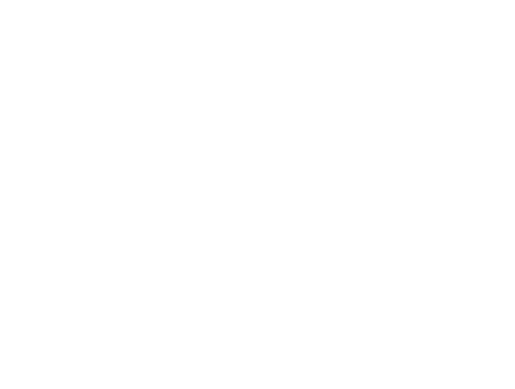

In [41]:
sub_directories = ['female', 'male']
make_fake_images_celeba('celeba-dataset/celeba/original-data/train/', 
                        'celeba-dataset/celeba/artificial-augmentation/train/', 
                        sub_directories, celeba_classes, sngan_wgan_gp_celeba)
make_fake_images_celeba('celeba-dataset/celeba/original-data/test/', 
                        'celeba-dataset/celeba/artificial-augmentation/test/', 
                        sub_directories, celeba_classes, sngan_wgan_gp_celeba)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


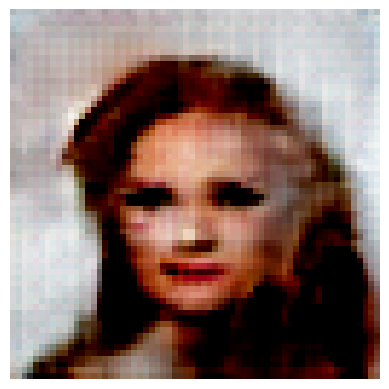

In [180]:
fake = make_fake_image(celeba_classes, 1, sngan_wgan_gp_celeba, is_celeba = True)
tensor_imagem = fake.permute(1, 2, 0)
plt.axis('off')
plt.imshow(np.array(tensor_imagem))
plt.savefig('image.png', bbox_inches='tight', pad_inches=0)
tensor_imagem = (tensor_imagem * 255).byte()
imagem_pil = Image.fromarray(tensor_imagem.numpy())
# Converter a imagem para o espaço de cores HSV


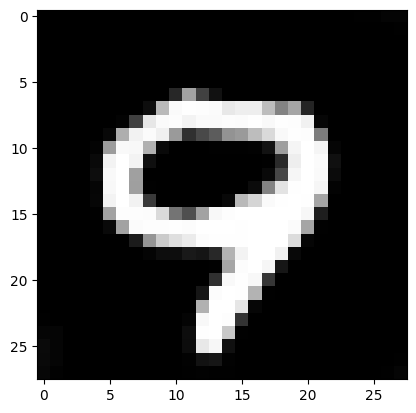

In [4]:
noise = utils.get_noise(n_samples = 1, input_dim = z_dim, device = device)
noise_conditional = torch.cat(tensors = (noise.float(), 
                                         F.one_hot(torch.tensor([9]), mnist_classes).float()), 
                                         dim = 1)
fake = sngan_wgan_gp_mnist(noise_conditional)
fake = fake.detach().cpu().view(-1, *gray_shape)
plt.imshow(fake[0, 0], cmap = 'gray')

In [7]:
np.array(fake[0, 0]).shape

(28, 28)